In [1]:
!pip install ta

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ta
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR

rcParams['figure.figsize']=(12,6)

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=0a32fe6e4d32fba7cc586711b2cddf15c8f0c8d00356c22ba137ffab2cce78be
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [2]:
df = yf.download('OJ=F')
juice_df = df.copy()
orange_df = df.copy()

[*********************100%***********************]  1 of 1 completed


In [3]:
orange_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
orange_df = orange_df[['Adj Close']]
orange_df.columns=['close']
orange_df.head()

,close
Date,
2021-09-07,147.000000
2021-09-08,143.100006
2021-09-09,144.250000
2021-09-10,147.100006
2021-09-13,142.100006


In [5]:
orange_df['SMA 15'] = orange_df.close.rolling(15).mean().shift(1)
orange_df['SMA 60'] = orange_df.close.rolling(60).mean().shift(1)
#Скользящее среднее

<Axes: xlabel='Date'>

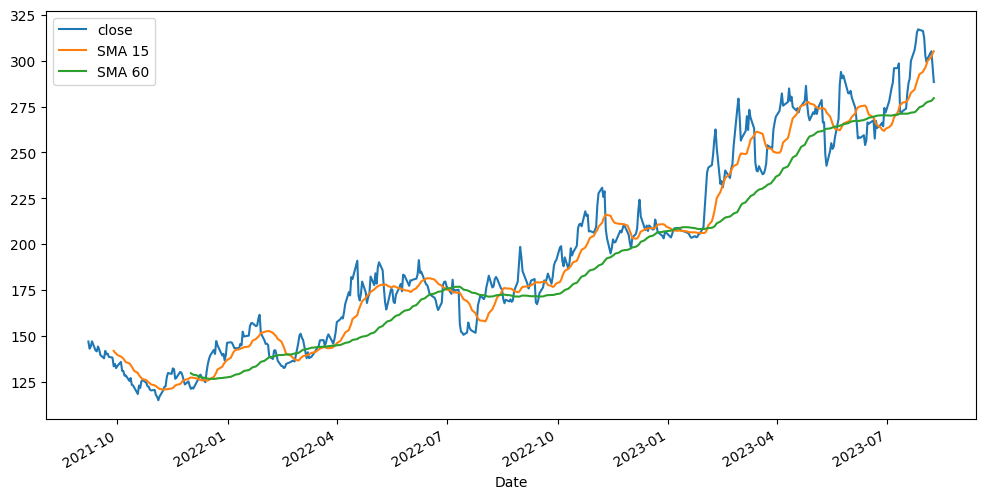

In [6]:
orange_df.plot()

In [7]:
orange_df['returns'] = orange_df.close.pct_change(1)
orange_df['MSD 15'] = orange_df.returns.rolling(15).std().shift(1)
orange_df['MSD 60'] = orange_df.returns.rolling(60).std().shift(1)

<Axes: xlabel='Date'>

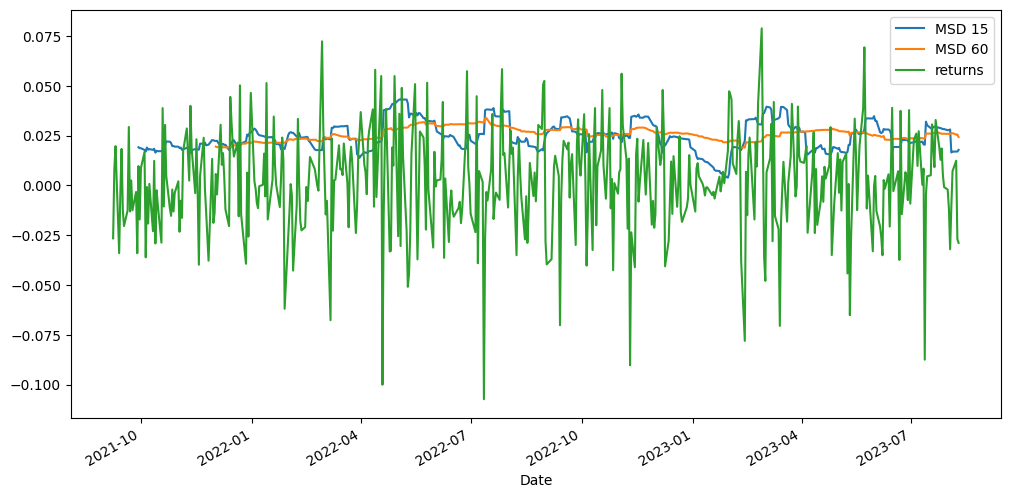

In [8]:
orange_df[['MSD 15', 'MSD 60', 'returns']].plot()

In [9]:
RSI = ta.momentum.RSIIndicator(orange_df.close)

In [10]:
orange_df['RSI'] = RSI.rsi()

<Axes: xlabel='Date'>

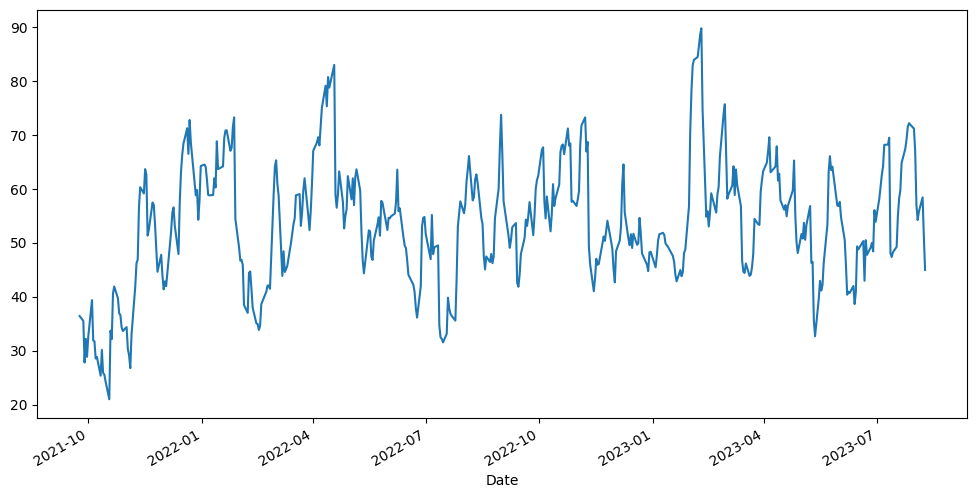

In [11]:
orange_df.RSI.plot()

# Linear Regression

In [12]:
orange_df.head(5)

,close,SMA 15,SMA 60,returns,MSD 15,MSD 60,RSI
Date,,,,,,,
2021-09-07,147.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-08,143.100006,NaN,NaN,-0.026531,NaN,NaN,NaN
2021-09-09,144.250000,NaN,NaN,0.008036,NaN,NaN,NaN
2021-09-10,147.100006,NaN,NaN,0.019757,NaN,NaN,NaN
2021-09-13,142.100006,NaN,NaN,-0.033990,NaN,NaN,NaN


In [13]:
orange_df = orange_df.iloc[62:]

In [14]:
train_size = int(df.shape[0]*0.75)
X_tr, X_ts = orange_df[['SMA 15',	'SMA 60', 'MSD 15',	'MSD 60',	'RSI']].iloc[:train_size], orange_df[['SMA 15',	'SMA 60', 'MSD 15',	'MSD 60',	'RSI']].iloc[train_size:]
y_tr, y_ts = orange_df[['returns']].iloc[:train_size], orange_df[['returns']].iloc[train_size:]
X_tr.shape, X_ts.shape

((363, 5), (59, 5))

In [15]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)

LinearRegression()

In [16]:
X = pd.concat([X_tr, X_ts], axis=0)

In [17]:
orange_df['prediction'] = lr.predict(X)

<ipython-input-17-353407d276eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orange_df['prediction'] = lr.predict(X)


<Axes: xlabel='Date'>

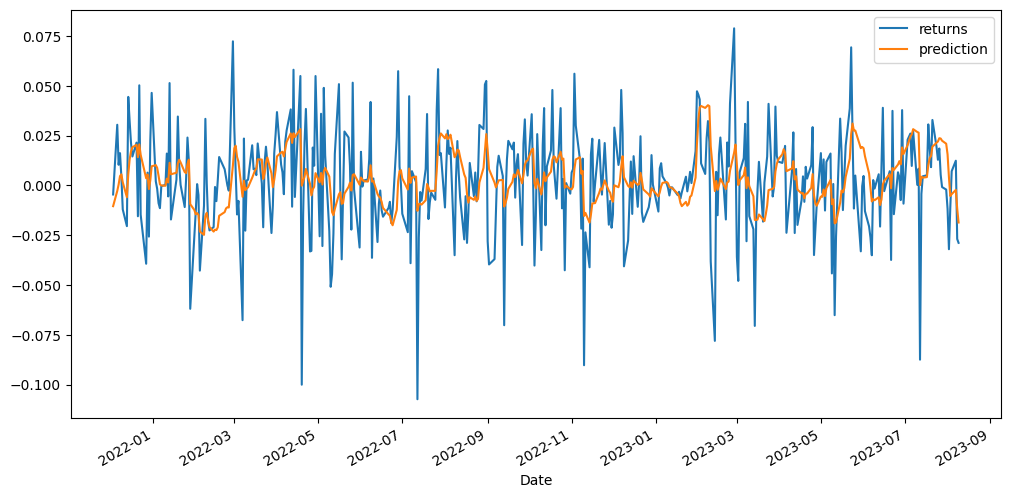

In [134]:
orange_df[['returns','prediction']].plot()

<Axes: xlabel='Date'>

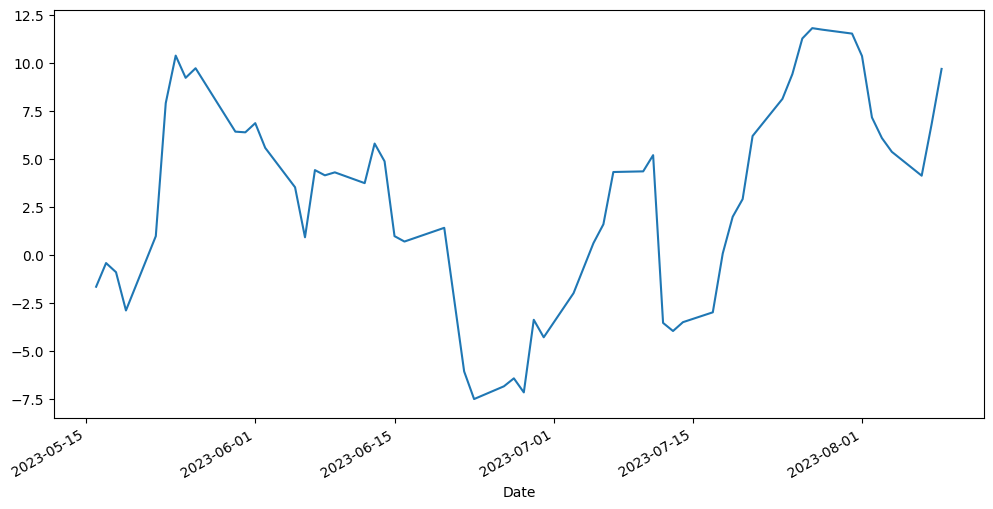

In [19]:
orange_df['position'] = np.sign(orange_df.prediction)
orange_df['strategy'] = orange_df.returns * orange_df.position.shift(1)
(orange_df.strategy.iloc[train_size:].cumsum()*100).plot()

# Alpha, Beta, Sortino Rate

In [20]:
return_series = juice_df['Adj Close'].pct_change(1).dropna()
return_series.name = 'return'

mean = return_series.mean()
vol = return_series[return_series<0].std()

sortino = 252**0.5 * mean/vol
print(f"Sortino: {'%.3f' % sortino}")

Sortino: 1.509


In [21]:
sp500 = yf.download('^GSPC')['Adj Close'].pct_change(1)
sp500.name = 'SP500'

val = pd.concat([return_series, sp500], axis=1).dropna()

cov_var_met = np.cov(val.values, rowvar=False)
cov = cov_var_met[0][1]
var = cov_var_met[1][1]

beta = cov/var
print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: -0.051


In [22]:
alpha = 252 * mean * (1 - beta) * 100
print(f"Alpha: {'%.3f' % alpha}")

Alpha: 45.552


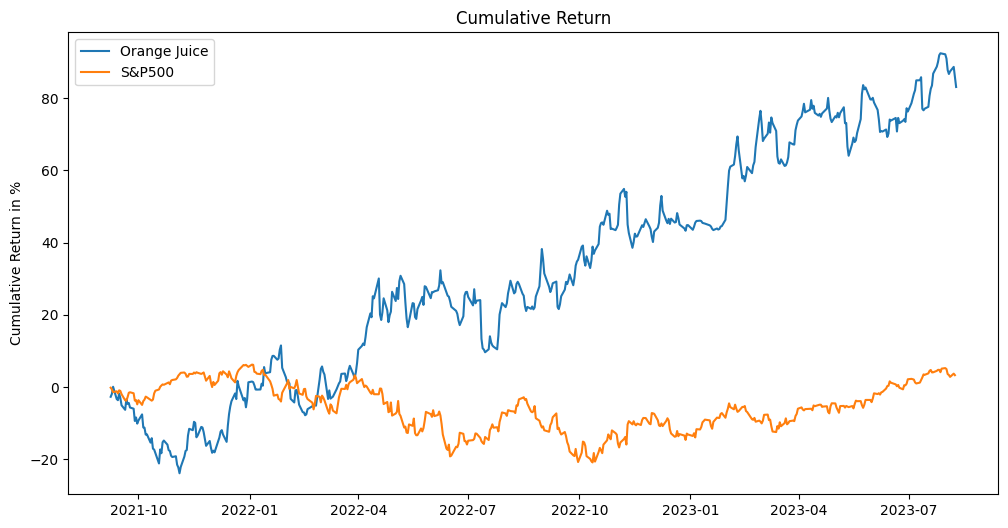

In [23]:
plt.plot(return_series.cumsum()*100, label='Orange Juice')
plt.plot(sp500.loc[sp500.index >= '2021-09-08'].cumsum()*100, label='S&P500')
plt.title('Cumulative Return')
plt.ylabel('Cumulative Return in %')
plt.legend()
plt.show()

# Просадка

In [24]:
def drawdown_func(series):
  cum = series.dropna().cumsum() + 1
  running_max = np.maximum.accumulate(cum)
  drawdown = cum / running_max - 1
  return drawdown

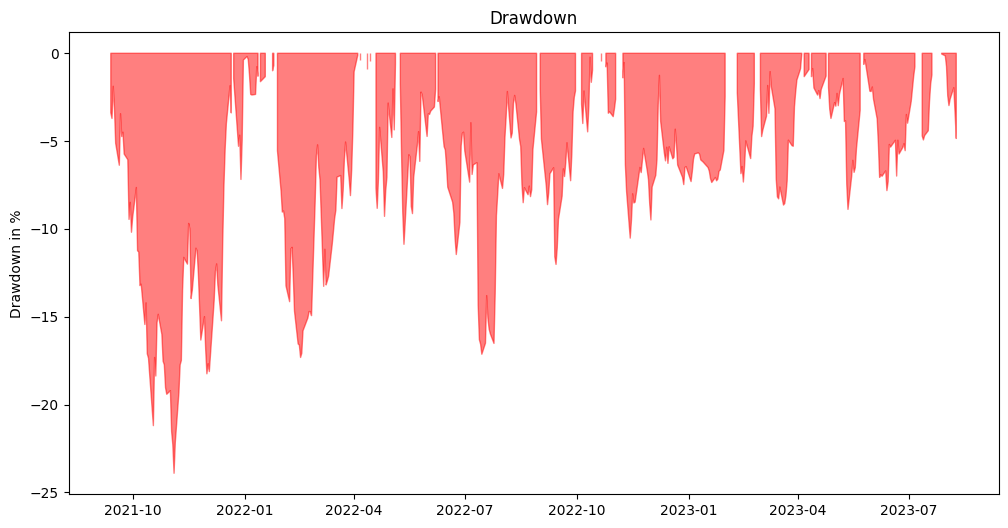

In [25]:
drawdown = drawdown_func(return_series)
plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, alpha=0.5, color='red')
plt.title('Drawdown')
plt.ylabel('Drawdown in %')
plt.show()

In [26]:
max_drawdown = min(drawdown) * 100
print(f'Max drawdown {"%.1f" % max_drawdown} %')

Max drawdown -23.9 %


# SVM

In [27]:
sv_df = df.copy()

In [28]:
def feature_engineering(df):
  df_copy = df.dropna().copy()
  df_copy['returns'] = df_copy.Close.pct_change(1)
  df_indicators = ta.add_all_ta_features(df = df, open='Open', high='High', low='Low', close='Adj Close', volume='Volume', fillna=True).shift(1)
  dfc = pd.concat((df_indicators, df_copy), axis=1)
  return dfc.dropna()

In [29]:
dfc = feature_engineering(sv_df)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [30]:
dfc.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dr,others_dlr,others_cr,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-08,147.000000,147.000000,147.000000,147.000000,147.000000,0.0,0.000000,0.0,0.000000,0.000000,...,-24.410914,0.000000,0.000000,145.550003,145.550003,144.000000,143.100006,143.100006,4,-0.026531
2021-09-09,145.550003,145.550003,144.000000,143.100006,143.100006,4.0,-8.645121,-4.0,-2.161280,-15.599976,...,-2.653057,-2.688886,-2.653057,144.250000,144.250000,144.250000,144.250000,144.250000,0,0.008036
2021-09-10,144.250000,144.250000,144.250000,144.250000,144.250000,0.0,-8.645121,-4.0,-2.161280,-13.371408,...,0.803630,0.800418,-1.870748,147.100006,147.100006,147.100006,147.100006,147.100006,462,0.019757
2021-09-13,147.100006,147.100006,147.100006,147.100006,147.100006,462.0,-8.645121,458.0,-0.018552,176.639196,...,1.975741,1.956476,0.068031,141.649994,142.699997,140.899994,142.100006,142.100006,349,-0.033990
2021-09-14,141.649994,142.699997,140.899994,142.100006,142.100006,349.0,107.692157,109.0,0.132138,-97.880689,...,-3.399048,-3.458159,-3.333329,143.000000,143.500000,139.050003,141.649994,141.649994,387,-0.003167


In [31]:
train_size = int(df.shape[0]*0.75)
X_tr1, X_ts1 = dfc.iloc[:train_size, 6:dfc.shape[1]-1], dfc.iloc[train_size:, 6:dfc.shape[1]-1]
y_tr1, y_ts1 = dfc[['returns']].iloc[:train_size], dfc[['returns']].iloc[train_size:]
X_tr1.shape, X_ts1.shape

((363, 92), (120, 92))

In [32]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_tr1)
X_test_sc = sc.transform(X_ts1)

In [33]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [34]:
X_train_sc.shape, X_train_pca.shape

((363, 92), (363, 5))

In [35]:
svr = SVR()
svr.fit(X_train_sc, y_tr1)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

<Axes: xlabel='Date'>

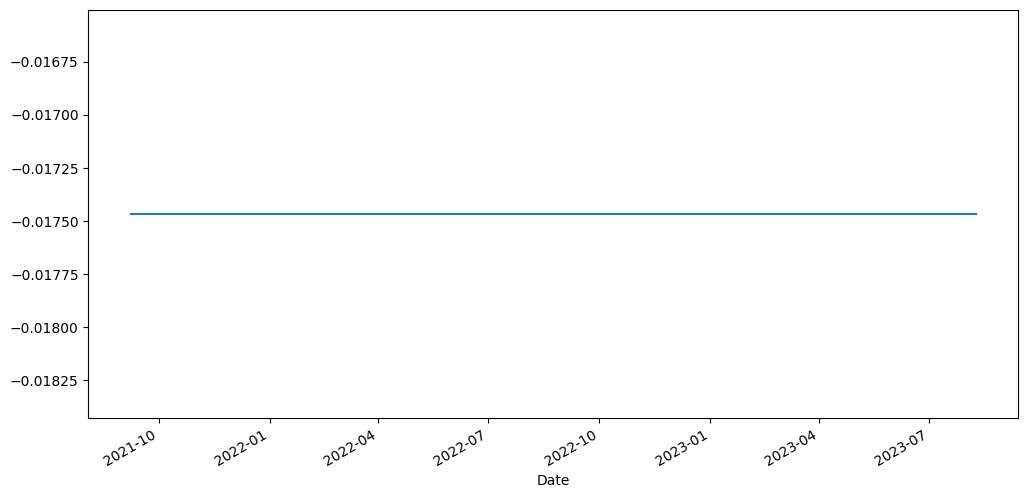

In [36]:
X = np.concatenate([X_train_sc, X_test_sc], axis=0)

dfc['prediction'] = svr.predict(X)
dfc.prediction.plot()

In [37]:
dfc['position'] = np.sign(dfc.prediction)
dfc['strategy'] = dfc.returns * dfc.position.shift(1)
dfc['return'] = dfc.strategy

# RNN

In [44]:
df = orange_df.drop(columns=['prediction',	'position',	'strategy'])

In [41]:
df.shape

(422, 10)

In [42]:
df.corr()

,close,SMA 15,SMA 60,returns,MSD 15,MSD 60,RSI,prediction,position,strategy
close,1.000000,0.972777,0.955022,0.037014,-0.034774,0.044480,0.206787,0.226340,0.059896,0.063558
SMA 15,0.972777,1.000000,0.979527,-0.053468,-0.003574,0.099501,-0.004701,0.018821,-0.104114,0.016336
SMA 60,0.955022,0.979527,1.000000,-0.030879,-0.074845,0.094067,-0.043330,0.077463,-0.072181,0.022615
returns,0.037014,-0.053468,-0.030879,1.000000,-0.038871,-0.067543,0.381292,0.430031,0.379543,0.423185
MSD 15,-0.034774,-0.003574,-0.074845,-0.038871,1.000000,0.431434,-0.127071,-0.055213,0.032310,-0.015322
MSD 60,0.044480,0.099501,0.094067,-0.067543,0.431434,1.000000,-0.301585,-0.179380,-0.146645,-0.067701
RSI,0.206787,-0.004701,-0.043330,0.381292,-0.127071,-0.301585,1.000000,0.847721,0.663426,0.235019
prediction,0.226340,0.018821,0.077463,0.430031,-0.055213,-0.179380,0.847721,1.000000,0.752975,0.249003
position,0.059896,-0.104114,-0.072181,0.379543,0.032310,-0.146645,0.663426,0.752975,1.000000,0.143602
strategy,0.063558,0.016336,0.022615,0.423185,-0.015322,-0.067701,0.235019,0.249003,0.143602,1.000000


In [166]:
train = int(df.shape[0]*0.75)
X_train, X_test, y_train, y_test = np.array(df.drop(columns='returns').iloc[:train]), np.array(df.drop(columns='returns').iloc[train:]), np.array(df.returns.iloc[:train]), np.array(df.returns.iloc[train:])
X_train.shape, X_test.shape

((316, 6), (106, 6))

In [167]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [168]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,  return_sequences=True),
    tf.keras.layers.LSTM(32,  return_sequences=True),
    tf.keras.layers.Dense(1)
])

model.compile(
      loss=tf.losses.MeanSquaredError(),
      optimizer=tf.optimizers.Adam(),
      metrics=[tf.metrics.MeanAbsoluteError()]
  )

history = model.fit(X_train, y_train, epochs=200, verbose=0, batch_size=4)

In [169]:
a = model.predict(np.concatenate([X_train, X_test], axis=0))
a = a.reshape(len(a),1)
orange_df['prediction1'] = a

14/14 [==============================] - 1s 2ms/step


<Axes: xlabel='Date'>

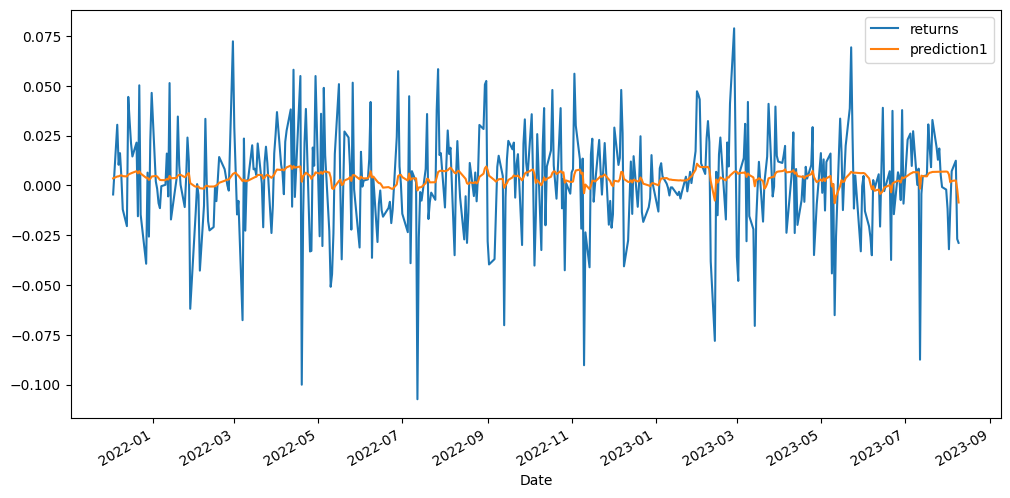

In [170]:
orange_df[['returns', 'prediction1']].plot()

In [171]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 7ms/step - loss: 5.9859e-04 - mean_absolute_error: 0.0181


[0.0005985869793221354, 0.018084177747368813]